In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import Trainer, TrainingArguments
import numpy as np 
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

DF = pd.read_excel("Data.xlsx")
le = LabelEncoder()
DF['Orientation'] = le.fit_transform(DF['Orientation'])
num_labels = len(DF['Orientation'].unique())

model_name = "allenai/scibert_scivocab_uncased"
model = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(model_name)


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [2]:
DF['Orientation'].value_counts()

1    502
0    366
2    325
Name: Orientation, dtype: int64

In [3]:
from torch.utils.data import TensorDataset, DataLoader
DF['text'] = DF[['TI', 'AB']].astype(str).agg(' '.join, axis=1)

In [4]:
print(DF.columns)

Index(['ID', 'Orientation', 'Impact', 'Gender', 'Area of  research - person',
       'Area of research - publication', 'UT', 'DOI', 'SOURCE YEAR',
       'Doc type', 'PersonID', 'Born', 'Position', 'TI', 'AB', 'text'],
      dtype='object')


In [17]:
train_df, test_df = train_test_split(DF, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1765, random_state=42) # 70, 15, 15 train test split


In [18]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def encode_data(tokenizer, df, text_column, label_column, max_length):
    encoded_data = tokenizer.batch_encode_plus(
        df[text_column].tolist(), # This line is used for the text column
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    labels = torch.tensor(df[label_column].values) # This line assigns the target variable 'Orientation'
    return encoded_data, labels

max_length = 512

# Apply encoding function to training, validation, and test data to go into data loader
train_encoded_data, train_labels = encode_data(tokenizer, train_df, "text", "Orientation", max_length)
val_encoded_data, val_labels = encode_data(tokenizer, val_df, "text", "Orientation", max_length)
test_encoded_data, test_labels = encode_data(tokenizer, test_df, "text", "Orientation", max_length)


In [19]:
# Create the respective dataloaders for SciBert models
def create_dataloader(encoded_data, labels, batch_size):
    dataset = TensorDataset(
        encoded_data["input_ids"],
        encoded_data["attention_mask"],
        labels
    )
    return DataLoader(dataset, batch_size=batch_size)

batch_size = 16


train_dataloader = create_dataloader(train_encoded_data, train_labels, batch_size)
val_dataloader = create_dataloader(val_encoded_data, val_labels, batch_size)
test_dataloader = create_dataloader(test_encoded_data, test_labels, batch_size)


In [20]:
from transformers import Trainer, TrainingArguments
import numpy as np 
from torch.utils.data import Dataset


# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=7, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, 
    warmup_steps=1000, 
    weight_decay=0.05, 

    logging_steps=10,
    save_steps=40,                     
    load_best_model_at_end=True,        
    evaluation_strategy='steps',         
    eval_steps=40,                      
    metric_for_best_model='eval_f1',     
    greater_is_better=True,              
)

def compute_accuracy(predictions, labels):
    assert len(predictions) == len(labels)
    correct_count = sum(p == l for p, l in zip(predictions, labels))
    return correct_count / len(predictions)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

class CustomDataset(Dataset):
    def __init__(self, tensor_dataset):

        self.tensor_dataset = tensor_dataset

    def __len__(self):
        return len(self.tensor_dataset)

    def __getitem__(self, idx):
        item = self.tensor_dataset[idx]
        return {
            "input_ids": item[0],
            "attention_mask": item[1],
            "labels": item[2],
        }    

train_dataset = CustomDataset(train_dataloader.dataset)
val_dataset = CustomDataset(val_dataloader.dataset)
test_dataset = CustomDataset(test_dataloader.dataset)


# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)




PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [21]:
# Train the model
trainer.train()


/Users/mitchellkijurina/miniconda3/envs/tensorflow/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 835
  Num Epochs = 7
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 371
  Number of trainable parameters = 109920771
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


  0%|          | 0/371 [00:00<?, ?it/s]

{'loss': 1.1221, 'learning_rate': 5.000000000000001e-07, 'epoch': 0.19}
{'loss': 1.1128, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.38}
{'loss': 1.1125, 'learning_rate': 1.5e-06, 'epoch': 0.57}


***** Running Evaluation *****
  Num examples = 179
  Batch size = 16


{'loss': 1.1, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.75}


  0%|          | 0/12 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-40
Configuration saved in ./results/checkpoint-40/config.json


{'eval_loss': 1.0936882495880127, 'eval_accuracy': 0.4022346368715084, 'eval_precision': 0.28185954617664294, 'eval_recall': 0.4022346368715084, 'eval_f1': 0.3174971138841029, 'eval_runtime': 28.2868, 'eval_samples_per_second': 6.328, 'eval_steps_per_second': 0.424, 'epoch': 0.75}


Model weights saved in ./results/checkpoint-40/pytorch_model.bin


{'loss': 1.0754, 'learning_rate': 2.5e-06, 'epoch': 0.94}
{'loss': 1.0596, 'learning_rate': 3e-06, 'epoch': 1.13}
{'loss': 1.0776, 'learning_rate': 3.5000000000000004e-06, 'epoch': 1.32}


***** Running Evaluation *****
  Num examples = 179
  Batch size = 16


{'loss': 1.0556, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.51}


  0%|          | 0/12 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-80
Configuration saved in ./results/checkpoint-80/config.json


{'eval_loss': 1.0475307703018188, 'eval_accuracy': 0.4748603351955307, 'eval_precision': 0.4348685106962802, 'eval_recall': 0.4748603351955307, 'eval_f1': 0.3577849980131367, 'eval_runtime': 28.2234, 'eval_samples_per_second': 6.342, 'eval_steps_per_second': 0.425, 'epoch': 1.51}


Model weights saved in ./results/checkpoint-80/pytorch_model.bin


{'loss': 1.0417, 'learning_rate': 4.5e-06, 'epoch': 1.7}
{'loss': 1.0429, 'learning_rate': 5e-06, 'epoch': 1.89}
{'loss': 1.0428, 'learning_rate': 5.500000000000001e-06, 'epoch': 2.08}


***** Running Evaluation *****
  Num examples = 179
  Batch size = 16


{'loss': 0.986, 'learning_rate': 6e-06, 'epoch': 2.26}


  0%|          | 0/12 [00:00<?, ?it/s]

/Users/mitchellkijurina/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results/checkpoint-120
Configuration saved in ./results/checkpoint-120/config.json


{'eval_loss': 0.9843561053276062, 'eval_accuracy': 0.5810055865921788, 'eval_precision': 0.44924208774640756, 'eval_recall': 0.5810055865921788, 'eval_f1': 0.48075729360645564, 'eval_runtime': 28.9914, 'eval_samples_per_second': 6.174, 'eval_steps_per_second': 0.414, 'epoch': 2.26}


Model weights saved in ./results/checkpoint-120/pytorch_model.bin


{'loss': 0.9431, 'learning_rate': 6.5000000000000004e-06, 'epoch': 2.45}
{'loss': 0.9851, 'learning_rate': 7.000000000000001e-06, 'epoch': 2.64}
{'loss': 0.9793, 'learning_rate': 7.5e-06, 'epoch': 2.83}


***** Running Evaluation *****
  Num examples = 179
  Batch size = 16


{'loss': 0.8982, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.02}


  0%|          | 0/12 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-160
Configuration saved in ./results/checkpoint-160/config.json


{'eval_loss': 0.9038885235786438, 'eval_accuracy': 0.5921787709497207, 'eval_precision': 0.5470246216521987, 'eval_recall': 0.5921787709497207, 'eval_f1': 0.554601028300966, 'eval_runtime': 30.3893, 'eval_samples_per_second': 5.89, 'eval_steps_per_second': 0.395, 'epoch': 3.02}


Model weights saved in ./results/checkpoint-160/pytorch_model.bin


{'loss': 0.899, 'learning_rate': 8.500000000000002e-06, 'epoch': 3.21}
{'loss': 0.7702, 'learning_rate': 9e-06, 'epoch': 3.4}
{'loss': 0.8256, 'learning_rate': 9.5e-06, 'epoch': 3.58}


***** Running Evaluation *****
  Num examples = 179
  Batch size = 16


{'loss': 0.7492, 'learning_rate': 1e-05, 'epoch': 3.77}


  0%|          | 0/12 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json


{'eval_loss': 0.8295141458511353, 'eval_accuracy': 0.6312849162011173, 'eval_precision': 0.6065354209892424, 'eval_recall': 0.6312849162011173, 'eval_f1': 0.5886304743707164, 'eval_runtime': 29.2954, 'eval_samples_per_second': 6.11, 'eval_steps_per_second': 0.41, 'epoch': 3.77}


Model weights saved in ./results/checkpoint-200/pytorch_model.bin


{'loss': 0.7794, 'learning_rate': 1.05e-05, 'epoch': 3.96}
{'loss': 0.7028, 'learning_rate': 1.1000000000000001e-05, 'epoch': 4.15}
{'loss': 0.6342, 'learning_rate': 1.1500000000000002e-05, 'epoch': 4.34}


***** Running Evaluation *****
  Num examples = 179
  Batch size = 16


{'loss': 0.5861, 'learning_rate': 1.2e-05, 'epoch': 4.53}


  0%|          | 0/12 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-240
Configuration saved in ./results/checkpoint-240/config.json


{'eval_loss': 0.8337249159812927, 'eval_accuracy': 0.6033519553072626, 'eval_precision': 0.5572525174848021, 'eval_recall': 0.6033519553072626, 'eval_f1': 0.5536411060484717, 'eval_runtime': 28.6043, 'eval_samples_per_second': 6.258, 'eval_steps_per_second': 0.42, 'epoch': 4.53}


Model weights saved in ./results/checkpoint-240/pytorch_model.bin


{'loss': 0.6527, 'learning_rate': 1.25e-05, 'epoch': 4.72}
{'loss': 0.6456, 'learning_rate': 1.3000000000000001e-05, 'epoch': 4.91}
{'loss': 0.5091, 'learning_rate': 1.3500000000000001e-05, 'epoch': 5.09}


***** Running Evaluation *****
  Num examples = 179
  Batch size = 16


{'loss': 0.4814, 'learning_rate': 1.4000000000000001e-05, 'epoch': 5.28}


  0%|          | 0/12 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-280
Configuration saved in ./results/checkpoint-280/config.json


{'eval_loss': 0.8435365557670593, 'eval_accuracy': 0.6089385474860335, 'eval_precision': 0.5889326876889664, 'eval_recall': 0.6089385474860335, 'eval_f1': 0.5850882143550281, 'eval_runtime': 28.6977, 'eval_samples_per_second': 6.237, 'eval_steps_per_second': 0.418, 'epoch': 5.28}


Model weights saved in ./results/checkpoint-280/pytorch_model.bin


{'loss': 0.4499, 'learning_rate': 1.45e-05, 'epoch': 5.47}
{'loss': 0.4312, 'learning_rate': 1.5e-05, 'epoch': 5.66}
{'loss': 0.4128, 'learning_rate': 1.55e-05, 'epoch': 5.85}


***** Running Evaluation *****
  Num examples = 179
  Batch size = 16


{'loss': 0.3351, 'learning_rate': 1.6000000000000003e-05, 'epoch': 6.04}


  0%|          | 0/12 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-320
Configuration saved in ./results/checkpoint-320/config.json


{'eval_loss': 0.8883777856826782, 'eval_accuracy': 0.6033519553072626, 'eval_precision': 0.602286955750643, 'eval_recall': 0.6033519553072626, 'eval_f1': 0.6008674771168249, 'eval_runtime': 28.8782, 'eval_samples_per_second': 6.198, 'eval_steps_per_second': 0.416, 'epoch': 6.04}


Model weights saved in ./results/checkpoint-320/pytorch_model.bin


{'loss': 0.2355, 'learning_rate': 1.65e-05, 'epoch': 6.23}
{'loss': 0.2272, 'learning_rate': 1.7000000000000003e-05, 'epoch': 6.42}
{'loss': 0.217, 'learning_rate': 1.75e-05, 'epoch': 6.6}


***** Running Evaluation *****
  Num examples = 179
  Batch size = 16


{'loss': 0.2411, 'learning_rate': 1.8e-05, 'epoch': 6.79}


  0%|          | 0/12 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-360
Configuration saved in ./results/checkpoint-360/config.json


{'eval_loss': 1.2746237516403198, 'eval_accuracy': 0.5027932960893855, 'eval_precision': 0.5585082288992903, 'eval_recall': 0.5027932960893855, 'eval_f1': 0.5105746209098164, 'eval_runtime': 28.644, 'eval_samples_per_second': 6.249, 'eval_steps_per_second': 0.419, 'epoch': 6.79}


Model weights saved in ./results/checkpoint-360/pytorch_model.bin


{'loss': 0.2673, 'learning_rate': 1.85e-05, 'epoch': 6.98}




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-320 (score: 0.6008674771168249).


{'train_runtime': 3992.6242, 'train_samples_per_second': 1.464, 'train_steps_per_second': 0.093, 'train_loss': 0.7476213936696476, 'epoch': 7.0}


TrainOutput(global_step=371, training_loss=0.7476213936696476, metrics={'train_runtime': 3992.6242, 'train_samples_per_second': 1.464, 'train_steps_per_second': 0.093, 'train_loss': 0.7476213936696476, 'epoch': 7.0})

In [22]:
eval_results = trainer.evaluate(val_dataset)
print(f"Validation set accuracy: {eval_results['eval_accuracy']:.2f}")


***** Running Evaluation *****
  Num examples = 179
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]

Validation set accuracy: 0.60


In [23]:
eval_results = trainer.evaluate(test_dataset)
print(f"Test set accuracy: {eval_results['eval_accuracy']:.2f}")
print(f"Test set precision: {eval_results['eval_precision']:.2f}")
print(f"Test set recall: {eval_results['eval_recall']:.2f}")
print(f"Test set F1-score: {eval_results['eval_f1']:.2f}")



***** Running Evaluation *****
  Num examples = 179
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]

Test set accuracy: 0.66
Test set precision: 0.68
Test set recall: 0.66
Test set F1-score: 0.66


***** Running Prediction *****
  Num examples = 179
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]

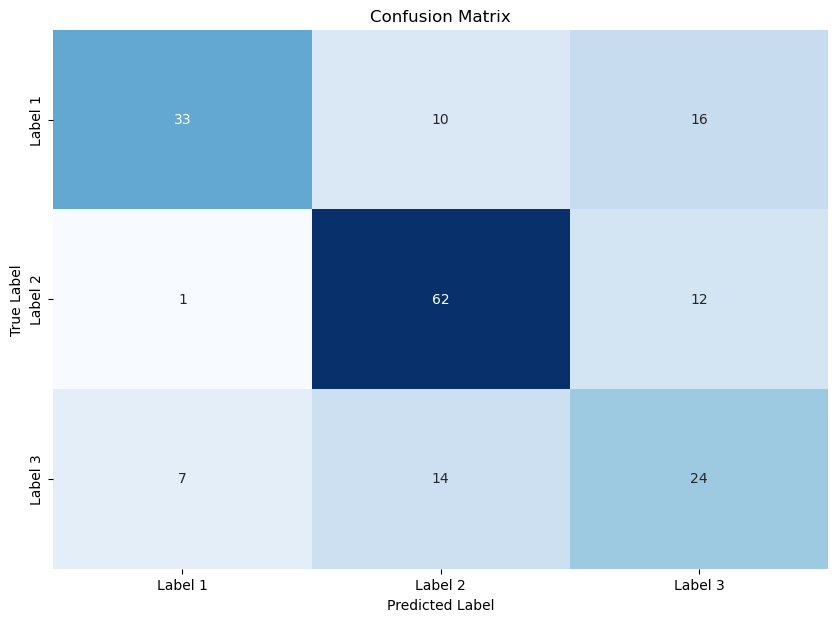

In [24]:
# Get predictions from the best model
predictions, label_ids, _ = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_mat = confusion_matrix(label_ids, predicted_labels)

# Create confusion matrix plot using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Label 1', 'Label 2', 'Label 3'], yticklabels=['Label 1', 'Label 2', 'Label 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# get the accuracy of the train data 
eval_results_train = trainer.evaluate(train_dataset)
print(f"train set accuracy: {eval_results_train['eval_accuracy']:.2f}")

***** Running Evaluation *****
  Num examples = 835
  Batch size = 16


  0%|          | 0/53 [00:00<?, ?it/s]

train set accuracy: 0.97
